In [2]:
%run data_package_loading.py # Code loads data as well as packages that are relevant across most project phases
%matplotlib inline


# !conda install -y psycopg2

from sklearn.feature_selection import SelectKBest, RFE, SelectFromModel, RFECV 
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

Xdb_1 = pd.read_pickle('data/madelon_db_1')
Xdb_2 = pd.read_pickle('data/madelon_db_2')
Xdb_3 = pd.read_pickle('data/madelon_db_3')


ydb_1 = Xdb_1['target']
ydb_2 = Xdb_2['target']
ydb_3 = Xdb_3['target']
Xdb_1 = Xdb_1.drop(['_id', 'target'], axis=1)
Xdb_2 = Xdb_2.drop(['_id', 'target'], axis=1)
Xdb_3 = Xdb_3.drop(['_id', 'target'], axis=1)

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:

# uci_features = ['28',  '48',  '64', '105', '128', '153', '241', '281', '318', '336', 
#                 '338', '378', '433', '442', '451', '453', '455', '472', '475', '493']

# madelon_features = ['feat_257', 'feat_269', 'feat_308', 'feat_315', 'feat_336',
#                    'feat_341', 'feat_395', 'feat_504', 'feat_526', 'feat_639',
#                    'feat_681', 'feat_701', 'feat_724', 'feat_736', 'feat_769',
#                    'feat_808', 'feat_829', 'feat_867', 'feat_920', 'feat_956']

# Xuci_1 = Xuci_1[uci_features]
# Xuci_2 = Xuci_2[uci_features]
# Xuci_3 = Xuci_3[uci_features]
# Xdb_1 = Xdb_1[madelon_features]
# Xdb_2 = Xdb_2[madelon_features]
# Xdb_3 = Xdb_3[madelon_features]

## Project 3 - Madelon
#### Daniel Johnston
#### DSI-plus2 SEA
[Github Repository](https://git.generalassemb.ly/dannyboyjohnston/project_3)


**Problem Statement**

The Madelon data as described by UCI: MADELON is an artificial dataset, which was part of the NIPS 2003 feature selection challenge. This is a two-class classification problem with continuous input variables. The difficulty is that the problem is multivariate and highly non-linear.

The objective is to develop a series of models for two purposes:

1. Identifying relevant features.
1. Generating predictions from the model.
    * Models will be scored on Accuracy, as this is a conventional metric for classification problem. 

Agenda:
1. Exploratory Data Analysis
1. Benchmarking
1. Feature Selection
1. Model Pipeline Development
1. Final Model Execution


## 1. EDA

We have 6 different datasets for this project.
* 3 samples of the UCI sourced data, each with 440 rows and 500 features. These are labeled `uci_1`, `uci_2`, and `uci_3`
* 3 samples of the database sourced data, each with ~20000 rows and 1000 features. These are labeled `db_1`, `db_2`, and `db_3`
    * Sample size varies based on the `TABLESAMPLE` arguement in `postgresql`
    
Let's take a look at the data 
1. Confirm the shape
2. Distribution of target
3. A sample of feature distributions
4. A sample of correlations between features and target

The complete output of charts and relevant code can be found in [0_EDA.ipynb](https://git.generalassemb.ly/dannyboyjohnston/project_3/blob/master/0_EDA.ipynb)

### 1-1. Confirm the shape

In [9]:
for Xy in [(Xuci_1, yuci_1, 'uci_1'), (Xuci_2, yuci_2, 'uci_2'), 
           (Xuci_3, yuci_3, 'uci_3'), (Xdb_1,  ydb_1, 'db_1'), 
           (Xdb_2,  ydb_2, 'db_2'), (Xdb_3,  ydb_3, 'db_3')]:
    print("\nOverview of", Xy[2])
    print("X shape:", Xy[0].shape)
    print("y shape:", Xy[1].shape)


1. Confirm the shape

Overview of uci_1
X shape: (440, 500)
y shape: (440,)

Overview of uci_2
X shape: (440, 500)
y shape: (440,)

Overview of uci_3
X shape: (440, 500)
y shape: (440,)

Overview of db_1
X shape: (19791, 1000)
y shape: (19791,)

Overview of db_2
X shape: (20006, 1000)
y shape: (20006,)

Overview of db_3
X shape: (20010, 1000)
y shape: (20010,)


### 1-2. Confirm the distribution of the target

It appears that the target classes are equally distributed.


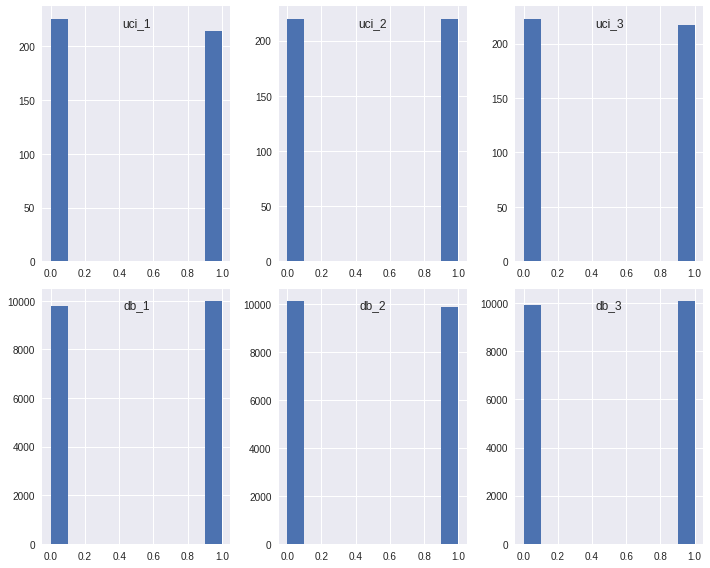

In [32]:
fig = plt.figure(figsize=(10,8))

for i, y in enumerate([(yuci_1, 'uci_1'), (yuci_2, 'uci_2'),
                       (yuci_3, 'uci_3'), ( ydb_1, 'db_1'), 
                       ( ydb_2, 'db_2'), ( ydb_3, 'db_3')]):
    fig.add_subplot(2,3,1+i)
    plt.hist(y[0])
    plt.title(y[1], y=0.90)


plt.tight_layout()
print("It appears that the target classes are equally distributed.")

### 1-3. A sample of feature distributions

Due to the number of features, plotting graphs for all features would be of limited value. At first glance, features appear to roughly normal. Histograms based on UCI data are more noisy due to the limited number of cases within each sample.

3. A sample of feature distributions.
Due to the number of features, plotting graphs for all features would be of limited value.
At first glance, features appear to roughly normal. Histograms based on UCI data are more noisy due to the limited number of cases within each sample.


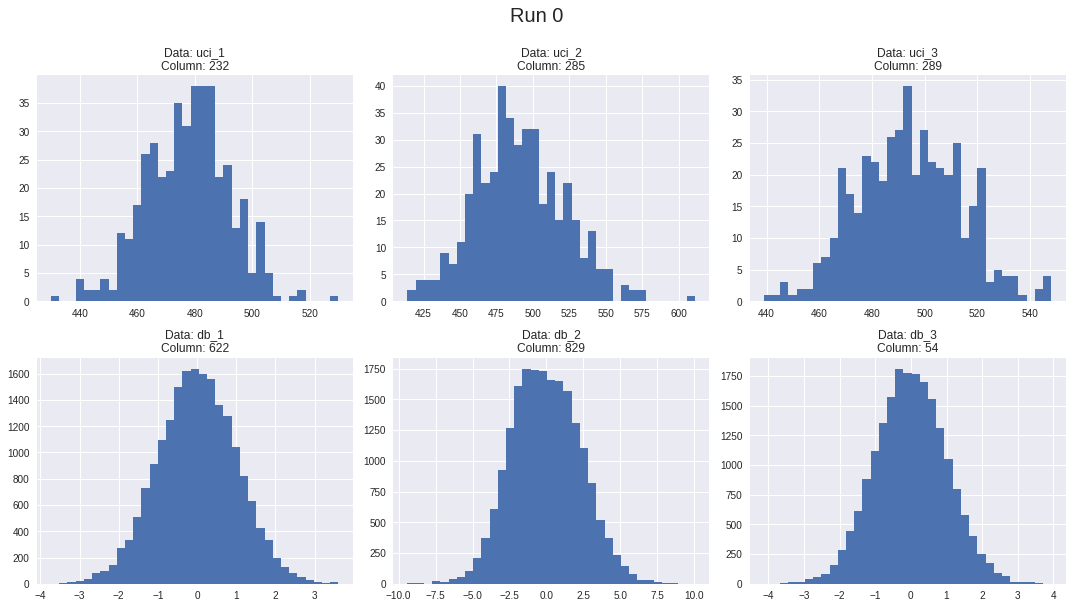

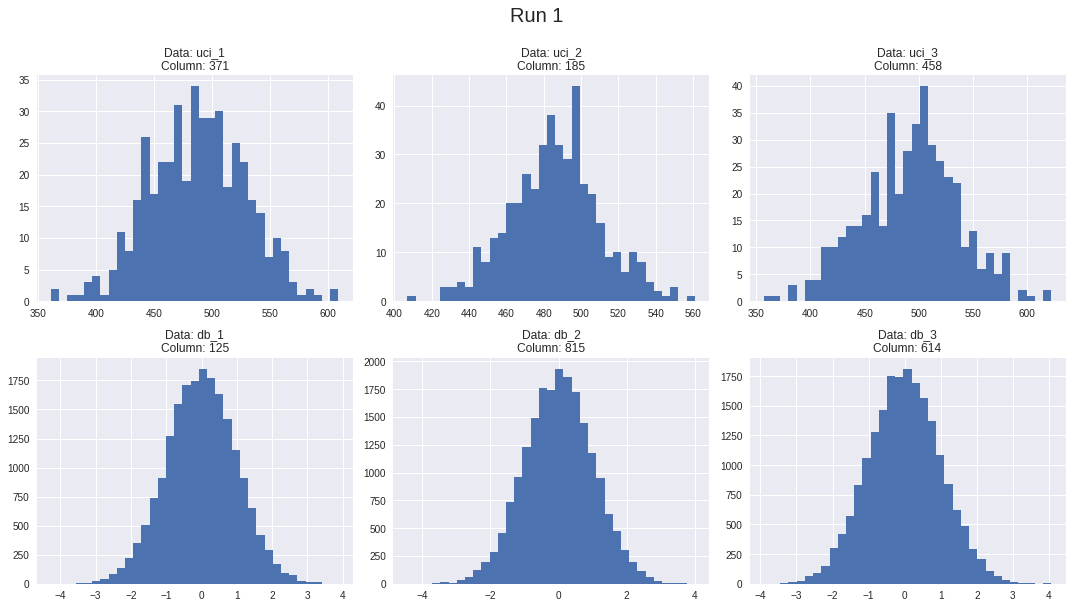

In [25]:
data_target = [(Xuci_1, yuci_1, 'uci_1'), 
               (Xuci_2, yuci_2, 'uci_2'), 
               (Xuci_3, yuci_3, 'uci_3'), 
               (Xdb_1,  ydb_1, 'db_1'), 
               (Xdb_2,  ydb_2, 'db_2'), 
               (Xdb_3,  ydb_3, 'db_3')]

for run in range(2):
    fig = plt.figure(figsize=(15,8))
    fig.suptitle("Run {}".format(run), fontsize=20, y=1.05)
    for i in range(len(data_target)):
        n_cols = len(data_target[i][0].columns) 
        col_i = np.random.randint(0, n_cols)
        temp_data = data_target[i][0][[col_i]]

        fig.add_subplot(2,3,i+1)
        plt.hist(temp_data.iloc[:, 0], bins = 35)
        plt.title("Data: " + data_target[i][2] + "\nColumn: " + str(col_i))

    plt.tight_layout()

### 1-4. A sample of correlations between features and target

Please note that not all datasets are shown here. There appear to be some features that are clearly more correlated with the target than others. However, we are expecting 20 informative features in the UCI data and an unknown number in the DB data. These correlations are not clear enough for us to conclusively identify the informative features.

1-4. A sample of correlations between features and target
Please note that not all datasets are shown here.
There appear to be some features that are clearly more correlated with the target than others. However, we are expecting 20 informative features in the UCI data and an unknown number in the DB data. These correlations are not clear enough for us to conclusively identify the informative features.


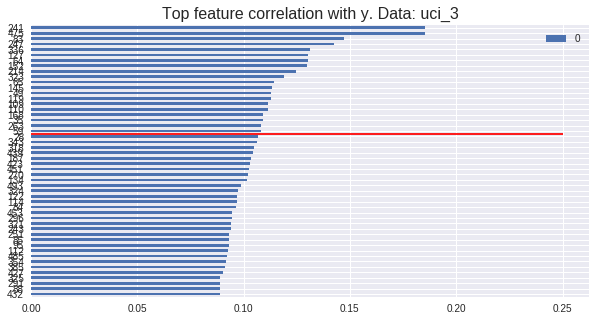

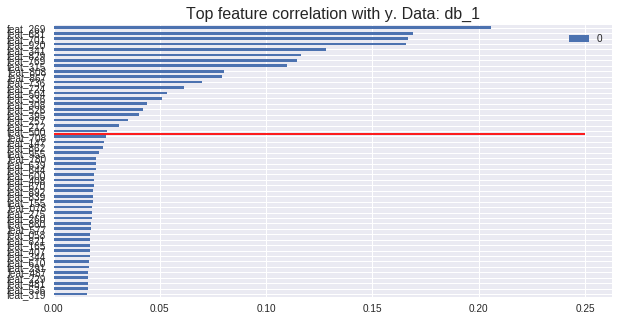

In [31]:
for Xy in data_target[2:4]:
    X = Xy[0]
    y = Xy[1]

    temp_corr = pd.DataFrame(abs(X.corrwith(y))) # using absoluted value to look at the largest magnitude correlations
    temp_corr = temp_corr.sort_values(0, ascending=False)

    temp_corr.head(50).plot.barh(figsize=(10, 5)).invert_yaxis()
    plt.hlines(20-0.5, 0, 0.25, colors='red') #cutoff to illustrate top 20 features. May not apply to db sourced data
    plt.title("Top feature correlation with y. Data: " + Xy[2], fontsize = 16)
    plt.show()

## 2. Benchmarking

In order to help assess the value of our work, it is important to give ourselves some baseline prediction scores. As we saw during our EDA, the target distribution is functionally uniform, i.e. 50/50. 

Before we invest too much time in feature selection and engineering, let us test a few different models. These models are naive (using the default settings.) These naive models are generally used to help inform us if our model tuning is helping or hurting. There is also a chance that a naive model will be very successful; from the description of the data as well as our EDA, we doubt that this will be the case.

To avoid overfitting, we did set the regularisation parameter to large value: `C = 10 ** 9`

The complete output of charts and relevant code can be found in [1_Benchmarking.ipynb](https://git.generalassemb.ly/dannyboyjohnston/project_3/blob/master/1_Benchmarking.ipynb)

In [15]:
benchmark_results_df = pd.read_csv('data/benchmark_results_df.csv')
# benchmark_results_df.head()

### 2-1. Logistic Regression
```
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C = C)
```

As we can see, the `LogisticRegression` model offeres offers only marginal improvement over randomly guessing a classification. 

In [12]:
benchmark_results_df[benchmark_results_df['model'].str.contains('Log') & 
                    benchmark_results_df['test_train'].str.contains('test')]

,data,model,scaler,score,test_train
1,uci_1,"LogisticRegression(C=1000000000, class_weight=...","StandardScaler(copy=True, with_mean=True, with...",0.466462,test
9,uci_2,"LogisticRegression(C=1000000000, class_weight=...","StandardScaler(copy=True, with_mean=True, with...",0.552273,test
17,uci_3,"LogisticRegression(C=1000000000, class_weight=...","StandardScaler(copy=True, with_mean=True, with...",0.522887,test
25,db_1,"LogisticRegression(C=1000000000, class_weight=...","StandardScaler(copy=True, with_mean=True, with...",0.527293,test
33,db_2,"LogisticRegression(C=1000000000, class_weight=...","StandardScaler(copy=True, with_mean=True, with...",0.529960,test
41,db_3,"LogisticRegression(C=1000000000, class_weight=...","StandardScaler(copy=True, with_mean=True, with...",0.531837,test


### 2-2. Decision Tree
```
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
```

Decision tress are looking better than `LogisticRegression` but still not very useful.

In [13]:
benchmark_results_df[benchmark_results_df['model'].str.contains('Dec') & 
                    benchmark_results_df['test_train'].str.contains('test')]

,data,model,scaler,score,test_train
3,uci_1,"DecisionTreeClassifier(class_weight=None, crit...","StandardScaler(copy=True, with_mean=True, with...",0.517785,test
11,uci_2,"DecisionTreeClassifier(class_weight=None, crit...","StandardScaler(copy=True, with_mean=True, with...",0.597727,test
19,uci_3,"DecisionTreeClassifier(class_weight=None, crit...","StandardScaler(copy=True, with_mean=True, with...",0.504547,test
27,db_1,"DecisionTreeClassifier(class_weight=None, crit...","StandardScaler(copy=True, with_mean=True, with...",0.612137,test
35,db_2,"DecisionTreeClassifier(class_weight=None, crit...","StandardScaler(copy=True, with_mean=True, with...",0.600156,test
43,db_3,"DecisionTreeClassifier(class_weight=None, crit...","StandardScaler(copy=True, with_mean=True, with...",0.597360,test


### 2-3. K Nearest Neighbors
```
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_jobs=-1)
```

Nearest Neighbors splits the difference between logistic regression and decision trees

In [14]:
benchmark_results_df[benchmark_results_df['model'].str.contains('KN') & 
                    benchmark_results_df['test_train'].str.contains('test')]

,data,model,scaler,score,test_train
5,uci_1,"KNeighborsClassifier(algorithm='auto', leaf_si...","StandardScaler(copy=True, with_mean=True, with...",0.545793,test
13,uci_2,"KNeighborsClassifier(algorithm='auto', leaf_si...","StandardScaler(copy=True, with_mean=True, with...",0.552273,test
21,uci_3,"KNeighborsClassifier(algorithm='auto', leaf_si...","StandardScaler(copy=True, with_mean=True, with...",0.544284,test
29,db_1,"KNeighborsClassifier(algorithm='auto', leaf_si...","StandardScaler(copy=True, with_mean=True, with...",0.541417,test
37,db_2,"KNeighborsClassifier(algorithm='auto', leaf_si...","StandardScaler(copy=True, with_mean=True, with...",0.549934,test
45,db_3,"KNeighborsClassifier(algorithm='auto', leaf_si...","StandardScaler(copy=True, with_mean=True, with...",0.528786,test


### 2-4. Support Vector Classification
```
from sklearn.svm import SVC
model = SVC(C = C)
```

The performance of SVC seems to be on par with KNN.

In [11]:
benchmark_results_df[benchmark_results_df['model'].str.contains('SVC') & 
                    benchmark_results_df['test_train'].str.contains('test')]

,data,model,scaler,score,test_train
7,uci_1,"SVC(C=1000000000, cache_size=200, class_weight...","StandardScaler(copy=True, with_mean=True, with...",0.509298,test
15,uci_2,"SVC(C=1000000000, cache_size=200, class_weight...","StandardScaler(copy=True, with_mean=True, with...",0.584091,test
23,uci_3,"SVC(C=1000000000, cache_size=200, class_weight...","StandardScaler(copy=True, with_mean=True, with...",0.581951,test
31,db_1,"SVC(C=1000000000, cache_size=200, class_weight...","StandardScaler(copy=True, with_mean=True, with...",0.543935,test
39,db_2,"SVC(C=1000000000, cache_size=200, class_weight...","StandardScaler(copy=True, with_mean=True, with...",0.544123,test
47,db_3,"SVC(C=1000000000, cache_size=200, class_weight...","StandardScaler(copy=True, with_mean=True, with...",0.562589,test


From our benchmarking, we have confirmed our suspision that some feature selection or feature engineering will be needed in order to achieve stronger results.

## 3. Feature Selection

Given our EDA and what we know about the data, feature selection will be one of the most steps we take during this project. For the UCI data, we know that there are 20 informative features that we need to identify, with 5 being true predictors and 15 being redundant linear combinations of the 5 true features. We do not know how many informative features there are in the Madelon data, but that it should follow a similar structure of some true predictors and some redundant linear combinations. 

This last point is important; we **know** that the informative features are at least partially related to each other. This will be key in identifying the informative features.

Three different techniques were used in trying to identify the informative features with varying levels of success:
1. Target prediction with individual features
2. Feature prediction with other features
3. Feature correlations

The complete notes and relevant code can be found in [2_Feature_Extraction_Iterative_Model_A.ipynb](https://git.generalassemb.ly/dannyboyjohnston/project_3/blob/master/2_Feature_Extraction_Iterative_Model_A.ipynb), [2_Feature_Extraction_Iterative_Model_B.ipynb](https://git.generalassemb.ly/dannyboyjohnston/project_3/blob/master/2_Feature_Extraction_Iterative_Model_B.ipynb), and [2_Feature_Extraction_Classification_and_Correlation.ipynb](https://git.generalassemb.ly/dannyboyjohnston/project_3/blob/master/2_Feature_Extraction_Classification_and_Correlation.ipynb)

### 3-1. Target prediction with individual features

Attempts were made to discern feature importance by fitting models of each individual feature against the target. The following naive models were used:
* `DecisionTreeClassifier()`
* `KNeighborsClassifier()`
* `LogisticRegression()`

The results of this approach were inconsistent accross datasets and ultimately unreliable. We expected that this would be the case given the distributions of feature correlations with the target. The results from this approach will not be further discussed.

The following function was used to test the different models:
```python
def feature_test(X, y, classifier):
    mean_scores = []
    
    # Run regresspr with Kfold
    for col in tqdm(X.columns):
        train_scores = []
        test_scores = []
        
        Xcol = X[[col]]
        
        # Set up Kfolds split
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42)
        skf.get_n_splits(Xcol, y)
        
        for train_cv_index, val_cv_index in skf.split(Xcol, y):
            X_train_temp = Xcol.iloc[train_cv_index, :]
            y_train_temp = y[train_cv_index]
            X_test_temp = Xcol.iloc[val_cv_index, :]
            y_test_temp = y[val_cv_index]
        
            #instantiate and fit
            model = classifier
            model.fit(X_train_temp, y_train_temp)
            
            #score
            train_scores.append(model.score(X_train_temp, y_train_temp))
            test_scores.append(model.score(X_test_temp, y_test_temp))
        
        #store mean scores for each feature
        mean_scores.append({'feature': col,
                            'train_score': np.array(train_scores).mean(),
                            'test_score': np.array(test_scores).mean()})
        
    df_scores = pd.DataFrame(mean_scores)
    return df_scores
```

### 3-2. Feature prediction with other features

As previously mentioned, we **know** that the informative features are largely related to eachother. The original true predictors are independent, but were then used to create linear combinations. This means we can test to see how well features can be predicted by other features to identify those that are most highly related.

`DecisionTreeRegressor` was used to test the relationship between variables.

The following functions were used:

```python
def calculate_r_2_for_feature(data, feature):
    tmp_X = data.drop(feature, axis=1)
    tmp_y = data[feature]

    X_train, X_test, y_train, y_test = train_test_split(tmp_X, tmp_y,test_size=0.25)
    
    # Pipe to scale and fit
    dtr_pipe = Pipeline([
                        ('scaler', StandardScaler()),
                        ('model', DecisionTreeRegressor())
                        ])
    
    dtr_pipe.fit(X_train, y_train)

    score = dtr_pipe.score(X_test, y_test)
    return score
```

```python
def mean_r2_for_feature(data, feature):
    scores = []
    for _ in range(5):
        tmp_score = calculate_r_2_for_feature(data, feature)
        scores.append(tmp_score)
        
        if tmp_score < 0:
            return np.array(scores).mean()
        
    scores = np.array(scores)
    return scores.mean()
```

```python
X_target = [(Xuci_1, 'uci_1'), 
            (Xuci_2, 'uci_2'), 
            (Xuci_3, 'uci_3'), 
            (Xdb_1, 'db_1'), 
            (Xdb_2, 'db_2'), 
            (Xdb_3, 'db_3')]

for data_src in X_target:
    results_R2 = []
    data = data_src[0]
    src = data_src[1]
    
    for feature in tqdm(data.columns):
        results_R2.append([feature, mean_r2_for_feature(data, feature)])
        
    results_df = pd.DataFrame(results_R2, columns = ['Feature', 'R2'])
    results_df.to_pickle('feature_results_' + src + '.pickle')

```

In [8]:
feature_results_uci_1 = pd.read_pickle("feature_results_uci_1.pickle")
feature_results_uci_2 = pd.read_pickle("feature_results_uci_2.pickle")
feature_results_uci_3 = pd.read_pickle("feature_results_uci_3.pickle")

uci_1_related_features = feature_results_uci_1.sort_values('R2', ascending = False).head(20).index
uci_2_related_features = feature_results_uci_2.sort_values('R2', ascending = False).head(20).index
uci_3_related_features = feature_results_uci_3.sort_values('R2', ascending = False).head(20).index

uci_1_related_features = np.array(uci_1_related_features.sort_values())
uci_2_related_features = np.array(uci_2_related_features.sort_values())
uci_3_related_features = np.array(uci_3_related_features.sort_values())

In [6]:
feature_results_uci_1.sort_values('R2', ascending = False).head(25)

,Feature,R2
64,64,0.958868
336,336,0.956095
451,451,0.953310
28,28,0.952888
128,128,0.950895
318,318,0.948276
281,281,0.945870
433,433,0.943008
105,105,0.941654
453,453,0.940853


As we can see, there is a very noticible drop in $R^{2}$ scores after the 20th feature. Scores go from positive to negative! 

Let's see if all three datasets returned consistent values:

In [9]:
print(uci_1_related_features == uci_2_related_features)
print(uci_1_related_features == uci_3_related_features)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


Great success! 

What about the database Madelon data? We don't know how many informative features there are. Let's take a look at the resulting $R^{2}$ scores.

In [10]:
feature_results_db_1 = pd.read_pickle("feature_results_db_1.pickle")
feature_results_db_2 = pd.read_pickle("feature_results_db_2.pickle")
feature_results_db_3 = pd.read_pickle("feature_results_db_3.pickle")

In [11]:
feature_results_db_1.sort_values('R2', ascending = False).head(25)

,Feature,R2
639,feat_639,0.956720
956,feat_956,0.953808
269,feat_269,0.908935
867,feat_867,0.902803
395,feat_395,0.890928
341,feat_341,0.890568
315,feat_315,0.877562
701,feat_701,0.865676
736,feat_736,0.854405
336,feat_336,0.852760


It looks like we are seeing the same drop to negative values we saw in the UCI data around the 20th feature in the DB data. Let's double check this across all three DB samples.

In [12]:
# Where is the cutoff? How many related features are there?
for df in [feature_results_db_1, feature_results_db_2, feature_results_db_3]:
    temp_df = df.sort_values('R2', ascending = False)
    
    counter = 0
    for i in temp_df['R2']:
#         print(i)
#         print(counter)
        if i < 0:
            print(counter)
            break
        counter = counter+1

20
20
20


20 features all around. That is a good sign; let's check if they are all the same features.

In [13]:
db_1_related_features = feature_results_db_1.sort_values('R2', ascending = False).head(20).index
db_2_related_features = feature_results_db_2.sort_values('R2', ascending = False).head(20).index
db_3_related_features = feature_results_db_3.sort_values('R2', ascending = False).head(20).index

db_1_related_features = np.array(db_1_related_features.sort_values())
db_2_related_features = np.array(db_2_related_features.sort_values())
db_3_related_features = np.array(db_3_related_features.sort_values())

In [14]:
db_1_related_features == db_2_related_features

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True], dtype=bool)

In [15]:
db_1_related_features == db_3_related_features

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True], dtype=bool)

Great success again.

In summary:
Each sample of UCI data suggests that the same 20 features are related, giving us high confidence that the following features are predictors of the target: 

`[28,  48,  64, 105, 128, 153, 241, 281, 318, 336, 338, 378, 433, 442, 451, 453, 455, 472, 475, 493]`

Each sample of Madelon DB data suggests that the same 20 features are related, giving us high confidence that the following features are predictors of the target: 

`[257, 269, 308, 315, 336, 341, 395, 504, 526, 639, 681, 701, 724, 736, 769, 808, 829, 867, 920, 956]`

While this approach appears to provide conclusive results, took a considerable amount of time to fit all of the necessary model. The next approach explores a faster alternative.

### 3-3. Feature correlations

Using the same intuition that the informative features are realated to one another, let's take a look at the correlation matrix.


In [16]:
corr_test = Xuci_1.corr()
corr_test.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,0.001863,-0.030589,0.079044,-0.016020,0.045018,-0.022883,0.002588,0.031829,0.026756,...,0.013224,0.034647,0.023064,-0.056057,-0.012904,-0.010460,0.017305,-0.055814,0.057639,-0.033592
1,0.001863,1.000000,-0.045873,0.112781,0.072174,0.027823,-0.086126,0.008964,-0.005845,-0.048256,...,0.007706,-0.101836,-0.027601,0.006410,0.049305,0.022063,0.048790,0.001745,-0.037004,0.060490
2,-0.030589,-0.045873,1.000000,-0.012340,-0.050528,0.060894,0.035209,-0.050305,0.059404,0.040547,...,0.012974,0.044949,0.097373,-0.016076,0.002061,-0.014319,0.039001,0.016703,0.015267,0.088202
3,0.079044,0.112781,-0.012340,1.000000,0.002612,0.064137,-0.011659,-0.070683,0.033268,-0.004106,...,0.032361,-0.031768,-0.043497,-0.000271,0.078904,0.012186,0.041357,-0.061805,-0.050831,0.034481
4,-0.016020,0.072174,-0.050528,0.002612,1.000000,0.000710,-0.049369,0.047841,-0.027970,-0.049692,...,-0.024900,0.002100,0.002794,0.042962,0.012581,-0.008397,0.042619,0.015844,-0.021339,-0.067939


That is is a very large matrix to manually inspect. Let's see if we can get `python` to make our job easier.

In [17]:
# zero at the diagonal.
for i in corr_test.columns:
    corr_test.loc[i,i] = 0

# take the absolute value of correlations. We only care about the magnitude, not the direction, of the correlations
corr_test = abs(corr_test)

corr_test.max().sort_values(ascending=False)[:25]

64     0.992330
336    0.992330
451    0.990578
28     0.990578
318    0.990541
153    0.990379
281    0.990379
433    0.990082
105    0.989993
128    0.989993
241    0.988937
475    0.988937
48     0.988595
378    0.988595
493    0.988309
453    0.988309
472    0.988133
442    0.988133
455    0.725369
338    0.685807
486    0.216672
269    0.216672
162    0.205203
389    0.205203
144    0.203834
dtype: float64

Similar to the $R^{2}$ scores, we are seeing a clear drop in the correlations after the 20th feature. Let's see if we get consistent sets of results across the different samples of data.

In [18]:
def test_corr(df):
    # get the absolute values of correlations
    corr_df = abs(df.corr())
    
    # zero out the diagonal
    for i in corr_df.columns:
        corr_df.loc[i,i] = 0
    
    top_features = corr_df.max().sort_values(ascending=False)[:20].index
    return np.array(top_features)

uci_1_features = test_corr(Xuci_1)
uci_2_features = test_corr(Xuci_2)
uci_3_features = test_corr(Xuci_3)

db_1_features = test_corr(Xdb_1)
db_2_features = test_corr(Xdb_2)
db_3_features = test_corr(Xdb_3)

uci_1_features.sort()
uci_2_features.sort()
uci_3_features.sort()
db_1_features.sort()
db_2_features.sort()
db_3_features.sort()

UCI data:

In [19]:
print(uci_1_features == uci_2_features)
print(uci_1_features == uci_3_features)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


Database data:

In [21]:
print(db_1_features == db_2_features)
print(db_1_features == db_3_features)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


### 3. Feature Selection Conclusion
We found two approaches that deliver the same set of informative features across all samples of our data.

* Feature prediction with other features
* Feature Correlations

These are both successful for the same core reason: the informative features are related to one another. While the **Feature prediction with other features** strikes us as more robust, due the repeated sampling and rigor of the model, the **Feature Correlations** strikes us as more scalable and efficient.